In [2]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [8]:
llm = ChatGroq(
    model='gemma2-9b-it'
)

In [9]:
from langchain_core.messages import AnyMessage
from typing import Annotated, TypedDict, Sequence
import operator
class AgentState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], operator.add]

In [12]:
def call_model(state: AgentState):
    last_message = state['messages'][-1]
    response = llm.invoke(last_message)
    return {
        "messages": [response.content]
    }

In [14]:
call_model({"messages": "Who are you?"})

{'messages': ["Please provide a question or statement so I can assist you. 😊 \n\nFor example, you could ask:\n\n* What is the weather like today in London?\n* Can you write a short poem about a cat?\n* How do I bake a chocolate cake?\n\n\nI'm ready for anything! ✨\n"]}

In [18]:
from langgraph.graph import START, END, MessagesState, StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("LLM", call_model)
workflow.add_edge(START, "LLM")
workflow.add_edge("LLM", END)

In [19]:
app = workflow.compile()

In [22]:
response = app.invoke({"messages": ["Who are you?"]})

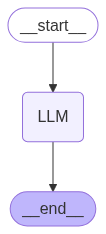

In [24]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
for output in app.stream({"messages": ["Who are you?"]}):
    for key,value in output.items():
        print(key)
        print("__________________")
        print(value)

LLM
__________________
{'messages': ["I am Gemma, an open-weights AI assistant. I am a large language model trained by Google DeepMind.\n\nEssentially, I'm a computer program that can understand and generate human-like text. I can answer your questions, write stories, summarize information, translate languages, and much more.\n\nBecause my weights are open, anyone can access and use me, which means developers and researchers can tinker with me, understand how I work, and even build upon my abilities.\n"]}


In [28]:
from langchain_core.tools import tool
@tool
def search(query:str):
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

In [31]:
search.invoke("what is a tempurature in kashmir?")

'the temp is 25 degree and cloudy'

In [32]:
tools = [search]
llm_with_tools = llm.bind_tools(tools)


In [34]:
response = llm_with_tools.invoke('what is a tempurature in kashmir?')

In [40]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'what is the temperature in kashmir'},
  'id': 'ebt7fe59m',
  'type': 'tool_call'}]

In [41]:
def router_function(state: MessagesState):
    message=state['messages']
    last_message=message[-1]
    if last_message.tool_calls:
        return 'tools'
    return END

In [ ]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("search", search)
workflow.add_node("", )

In [ ]:
from langchain_core.tools import tool
